In [13]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.dtypes)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [14]:
# string label to categorical values
from sklearn.preprocessing import LabelEncoder

for i in range(train.shape[1]):
    if train.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(train.iloc[:,i].values) + list(test.iloc[:,i].values))
        train.iloc[:,i] = lbl.transform(list(train.iloc[:,i].values))
        test.iloc[:,i] = lbl.transform(list(test.iloc[:,i].values))


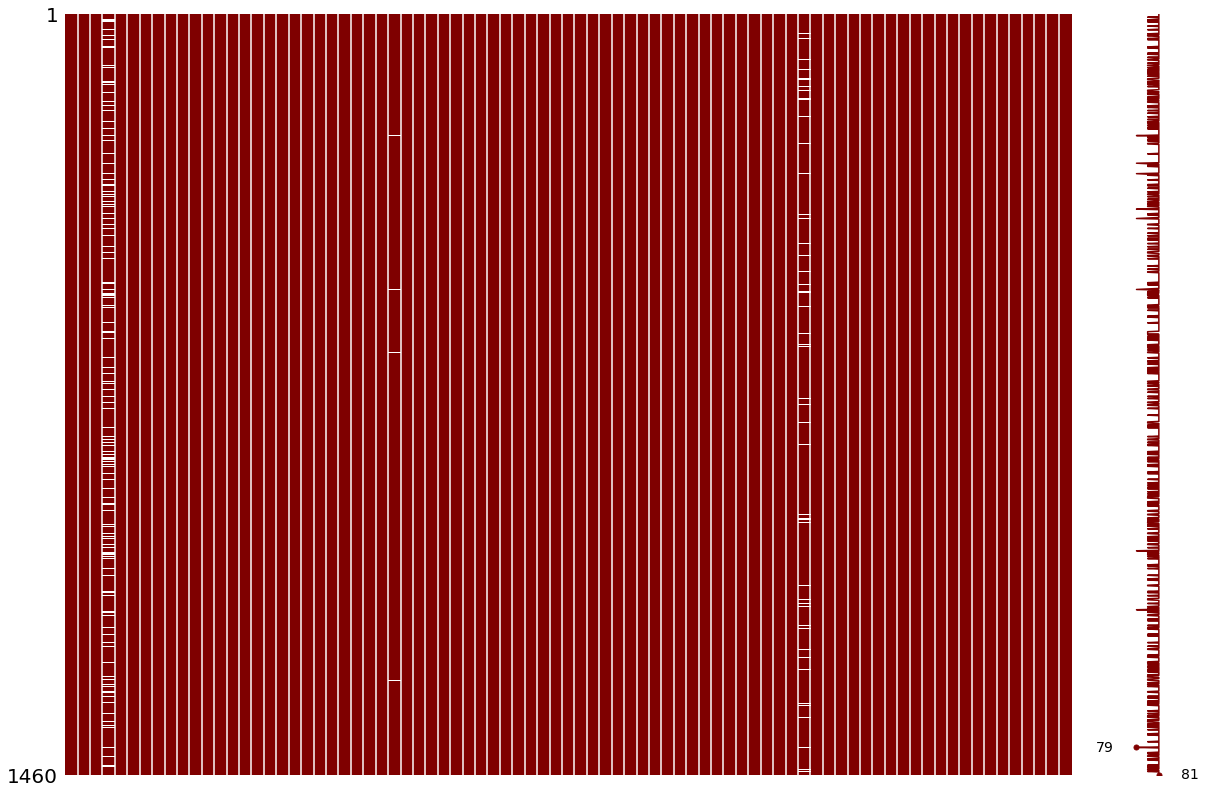

In [16]:
# search for missing data
import missingno as msno
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

In [17]:
# keep ID for submission
train_ID = train['Id']
test_ID = test['Id']

# split data for training
y_train = train['SalePrice']
X_train = train.drop(['Id','SalePrice'], axis=1)
X_test = test.drop('Id', axis=1)
X_train = X_train.fillna(X_train.median())

# dealing with missing data
Xmat = pd.concat([X_train, X_test])
Xmat = Xmat.drop(['LotFrontage','MasVnrArea','GarageYrBlt'], axis=1)
Xmat = Xmat.fillna(Xmat.median())

# add a new feature 'total sqfootage' なぜ新しい特徴量を作るのか
Xmat['TotalISF'] = Xmat['TotalBsmtSF']+Xmat['1stFlrSF']+Xmat['2ndFlrSF']

/home/ec2-user/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


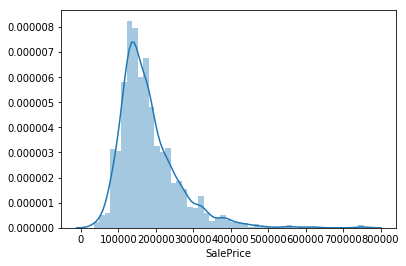

In [18]:
# normality check for the target

ax = sns.distplot(y_train)
plt.show()

/home/ec2-user/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


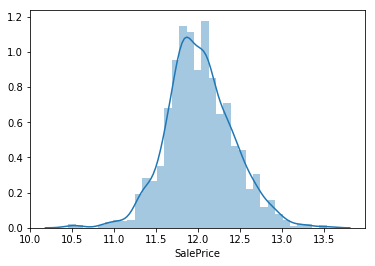

In [19]:
# log-trainsform the dependent variable for normality

y_train = np.log(y_train) # なぜlogを取ると正規分布に近づくのか？

ax = sns.distplot(y_train)
plt.show()

Training done using Random Forest


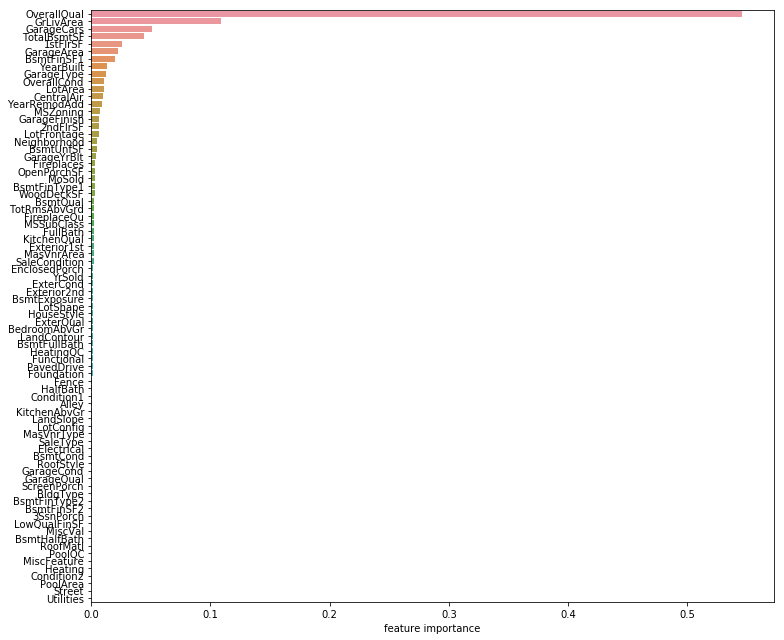

In [20]:
# feature importance using random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=80, random_state=0)
rf.fit(X_train, y_train)
print('Training done using Random Forest')

ranking = np.argsort(-rf.feature_importances_)
f,ax = plt.subplots(figsize=(11,9))
sns.barplot(x=rf.feature_importances_[ranking],y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

In [21]:
# use the top 30 features only
X_train = X_train.iloc[:,ranking[:30]]
X_test = X_test.iloc[:,ranking[:30]]

# interaction between the top2
X_train["Interaction"] = X_train["GrLivArea"]*X_train["OverallQual"]
X_test["Interaction"] = X_test["GrLivArea"]*X_test["OverallQual"]

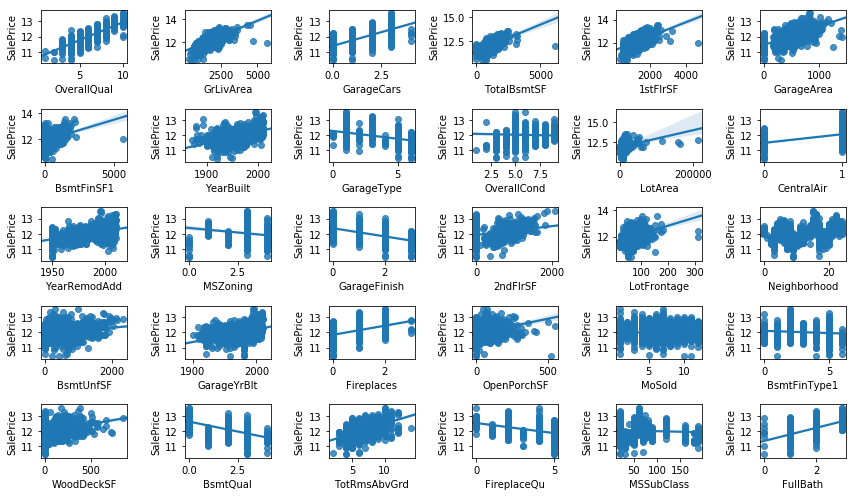

In [22]:
fig = plt.figure(figsize=(12,7))
for i in np.arange(30):
    ax = fig.add_subplot(5,6,i+1)
    sns.regplot(x=X_train.iloc[:,i],y=y_train)
    
plt.tight_layout()
plt.show()

In [30]:
# XGBBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

print("Parameter optimization")
xgb_model = xgb.XGBRegressor()
reg_xgb = GridSearchCV(xgb_model,
                      {'max_depth':[2,4,6],
                      'n_estimators':[50,100,200]}, verbose=1)
reg_xgb.fit(X_train, y_train)

Parameter optimization
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    4.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 4, 6], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [31]:
# Don't forget to convert the prediction back to non-log scale
y_pred = np.exp(reg_xgb.predict(X_test))

# submission
submission = pd.DataFrame({
        "Id": test_ID,
        "SalePrice":y_pred
    })
submission.to_csv('houseprice.csv',index=False)